In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline
%config InlineBackend.figure_format = 'svg'

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Environment 🌎

### MLflow is a useful tool to track experiment results

cd to the root directory of this lesson (in my case `/Users/paulabartabajo/src/online-courses/hands-on-rl/03_cart_pole`) and spin up the mlflow tracking server as follows:

**$ mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./artifacts --host 0.0.0.0 --port 5000**

### 💡 if you have another service listening to port 5000, increase port number by 1 until you hit a free port.

In [2]:
try:
    import mlflow
    print("mlflow already installed")
except ImportError:
    !python -m pip install -q mlflow
    print("Installed mlflow")

# connect mlflow client to the mlflow server that runs on localhost:5000
MLFLOW_SERVER_URI = 'http://localhost:5000'

mlflow.set_tracking_uri(str(MLFLOW_SERVER_URI))

print("connected")

EXPERIMENT_NAME = 'nn_layers_search5'
mlflow.set_experiment(EXPERIMENT_NAME)
print("set")


mlflow already installed
connected


2022/07/04 23:04:13 INFO mlflow.tracking.fluent: Experiment with name 'nn_layers_search5' does not exist. Creating a new experiment.


set


## Create an Optuna study

In [3]:
try:
    import optuna
    print("optuna already installed")
except ImportError:
    !python -m pip install -q optuna
    print("Installed optuna")

from src.config import OPTUNA_DB

study = optuna.create_study(
    study_name=EXPERIMENT_NAME,
    direction='maximize',
    load_if_exists=True,
    storage=f'sqlite:///{OPTUNA_DB}'
)

[I 2022-07-04 23:04:14,817] A new study created in RDB with name: nn_layers_search5


optuna already installed


## Objective function we want to maximize

In [4]:
from src.optimize_hyperparameters import objective

# we define a lambda function because study.optimize()
# expect the objective function to have only 1 input
# (trial), while our objective function hast 2 extra
# inputs I defined to add flexibility to the script

from mlagents_envs.environment import UnityEnvironment
env_name = "TouchCube"
    
try:
    env.close()
except:
    pass

env = UnityEnvironment(file_name=env_name, no_graphics=True, worker_id=1)
func = lambda trial: objective(trial,
                               force_linear_model=False,
                               n_episodes_to_train=50, 
                               env=env)

[INFO] Connected to Unity environment with package version 1.2.0-preview and communication version 1.0.0


INFO:mlagents_envs.environment:Connected to Unity environment with package version 1.2.0-preview and communication version 1.0.0


## Set threshold to terminate hyperparameter search

In [5]:
class CheckHyperparamMeanRewardThreshold:
    def __init__(self, reward_threshold: float):
        self.reward_threshold = reward_threshold

    def __call__(self, study: optuna.study.Study, trial: optuna.trial.FrozenTrial) -> None:
        if trial.value >= self.reward_threshold:
            print((f'Stopping hyperparameter search because trial.value ({trial.value}) '
                   f'hit threshold ({self.reward_threshold})'))
            study.stop()

# Stop hyperparameter search when we hit a perfect mean reward of mean_reward_to_stop
mean_reward_to_stop = 10
hyperparam_search_stop_callback = CheckHyperparamMeanRewardThreshold(mean_reward_to_stop)

In [6]:
import warnings
warnings.filterwarnings('ignore')

## Let's start the search

In [ ]:
study.optimize(func, n_trials=50, callbacks=[hyperparam_search_stop_callback])

[INFO] Connected new brain: TouchCube?team=0


INFO:mlagents_envs.environment:Connected new brain: TouchCube?team=0


num agents  1
action size  3
state size  11
Agent state looks like: 
[[ 0.5607624   0.59327745  0.5607624   0.2900301   0.59327745  0.5
   0.7099699   0.5         0.         -0.         -0.        ]]
PARAMS: nn_layers =  2  nn_hidden_layers =  8
epoch 38 success rate 0.00 ep_mean_r -500.00 exploration 1.95          

## These are the best hyper-parameters

In [ ]:
best_trial = study.best_trial

hparams = {k: best_trial.params[k] for k in best_trial.params if k != 'seed'}
#hparams['nn_hidden_layers'] = eval(hparams['nn_hidden_layers']) 
print(hparams)

#SEED = best_trial.params['seed']
#print('Seed: ', SEED)

## We can re-run the training to get the perfect agent

In [11]:
from src.utils import set_seed
set_seed(env, SEED)

from src.q_agent import QAgent
agent = QAgent(env, **hparams)

from src.loops import train
train(agent, env, n_episodes=200)

67,586 parameters


100%|█████████████████████████████████████████████████████████████████████| 200/200 [00:13<00:00, 15.12it/s]

Reward mean: 337.64, std: 29.49
Num steps mean: 337.64, std: 29.49


## or simply load the `agent_id` from the best run

In [3]:
from src.q_agent import QAgent
from src.config import SAVED_AGENTS_DIR

# you can find the agent_id for the best run in the MLflow
# dashboard.
# 298 is the value in my case, but you need to check what is your
agent_id = 298

path_to_saved_model = SAVED_AGENTS_DIR / 'CartPole-v1' / str(agent_id)
agent = QAgent.load_from_disk(env, path_to_saved_model)

67,586 parameters


## Evaluate the agent ⏱️

In [4]:
from src.loops import evaluate
rewards, steps = evaluate(
    agent, env,
    n_episodes=1000,
    epsilon=0.00
)

100%|███████████████████████████████████████████████████████████████████| 1000/1000 [03:00<00:00,  5.54it/s]


In [5]:
import numpy as np
reward_avg = np.array(rewards).mean()
reward_std = np.array(rewards).std()
print(f'Reward average {reward_avg:.2f}, std {reward_std:.2f}')

Reward average 500.00, std 0.00


## Let's see how far we got in each attempt

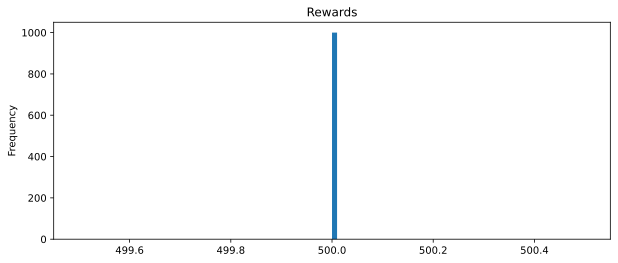

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

fig, ax = plt.subplots(figsize = (10, 4))
ax.set_title("Rewards")    
pd.Series(rewards).plot(kind='hist', bins=100)

plt.show()

## Let's see our agent in action 🎬

In [49]:
# Workaround for pygame error: "error: No available video device"
# See https://stackoverflow.com/questions/15933493/pygame-error-no-available-video-device?rq=1
# This is probably needed only for Linux
import os
os.environ["SDL_VIDEODRIVER"] = "dummy"

from src.viz import show_video

show_video(agent, env, sleep_sec=0.01, seed=123)